# 1. インポート

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.interpolate import pchip_interpolate

# 2. データの準備

In [2]:
# 1. グラフから抽出した主要な制御点 (Distance, Depth)
distance_points = np.array([
    0, 60, 62, 65, 70, 80, 85, 95, 100, 103, 105, 107, 115, 120, 125, 133, 135, 138, 140, 150, 250
])
depth_points = np.array([
    -0.21, -0.21, -0.4, -0.6, -0.55, -0.8, -1.2, -1.3, -2.1, -1.9, -1.65, -1.85, -1.78, -1.8, -2.0, -2.1, -2.3, -2.5, -2.7, -2.72, -2.73
])

dist_pts = np.array([
    0, 10, 30, 50, 60, 61.5, 63, 65, 75, 80, 88, 95, 103, 105, 107, 110, 115, 120, 125, 130, 135, 138, 145, 150, 250
])
wave_pts = np.array([
    -1.2, -1.6, -0.5, 1.6, 1.6, 3.7, 1.2, 1.7, 2.5, 2.3, 1.6, 2.6, 0.2, 1.7, 0.7, 0.7, 1.2, 1.1, 1.5, 1.5, 2.0, 0.5, 0.05, 0, 0
])

# 2. 0.5km刻みの軸を作成 (0kmから249.5kmまで)
x = np.arange(0, 250, 0.5)

# 3. PCHIP補間
H_minus = pchip_interpolate(distance_points, depth_points, x)
eta0 = pchip_interpolate(dist_pts, wave_pts, x)


## 3. 関数の準備

In [3]:
# 1次元浅水波モデル(1ステップ)
def step_forward(eta, u, H, nx, g, dx, CFL):
  dt = CFL * dx / np.sqrt(g * np.max(H))
  c_out = np.sqrt(g * H[-1])

  # 運動方程式
  u_new = u.copy()
  eta_new = eta.copy()

  u_new[1:nx] = u[1:nx] - (g * dt / dx) * (eta[1:nx] - eta[0:nx-1])
  u_new[0] = 0.0    # 沿岸境界
  u_new[nx] = u[nx] - (c_out * dt / dx) * (u[nx] - u[nx-1])  # 放射境界

  # 連続の式
  eta_new[0:nx] = eta[0:nx] - (dt / dx) * H[0:nx] * (u_new[1:nx+1] - u_new[0:nx])
  # 対流流出条件
  eta_new[-1] = eta[-1] - (c_out * dt / dx) * (eta[-1] - eta[-2])

  return eta_new, u_new

In [4]:
# etaとuを状態ベクトルとしてまとめる
def pack(eta, u):
    return np.concatenate([eta, u])

# 状態ベクトルをetaとuに分解する
def unpack(v, nx):
    # v の前半 nx 個が eta, 後半 nx+1 個が u
    eta = v[:nx]
    u = v[nx:]
    return eta, u

In [5]:
# 観測行列の作成
def create_H_matrix(nx, interval, missing_idx=None):
    n_state = 2 * nx + 1    # 状態次元
    # 1. 観測候補点のインデックス
    obs_indices = np.arange(0, nx, interval)

    # 2. missing_idxがNoneなら空リストにする
    if missing_idx is None:
        missing_idx = []

    # 欠損インデックスを除く
    obs_indices = [idx for idx in obs_indices if idx not in missing_idx]

    n_obs = len(obs_indices)     # 観測次元
    H = np.zeros((n_obs, n_state))

    # 3. 行列の組み立て
    for i, idx in enumerate(obs_indices):
        H[i, idx] = 1

    return H, np.array(obs_indices), n_state, n_obs

# 4. EnKFの準備

## 4-1. パラメータ設定

In [6]:
eta = eta0.copy()             # 初期水位 η(x,0)
H = np.abs(H_minus) * 1000.0        # 水深 [m]
nx = len(H)                       # 空間格子点数

u = np.zeros(nx + 1)              # スタガード格子流速

g = 9.81                          # 重力加速度 [m/s^2]
dx = 500.0                        # 空間刻み [m]

total_time = 3000.0               # 総計算時間 [s]
CFL = 0.5                         # CFL数

dt = CFL * dx / np.sqrt(g * np.max(H))
nt = int(total_time / dt)

## 4-2. 正解データの作成

In [7]:
eta_true_history = np.zeros((nt, nx))
u_true_history = np.zeros((nt, nx + 1))

eta_curr = eta0.copy()
u_curr = np.zeros(nx + 1)

for t_step in range(nt):
        eta_curr, u_curr = step_forward(eta_curr, u_curr, H, nx, g, dx, CFL)

        # 履歴保存
        eta_true_history[t_step, :] = eta_curr
        u_true_history[t_step, :] = u_curr

# 5. アンサンブルカルマンフィルタの実装

## 5-1. 関数の準備

In [8]:
# アンサンブルカルマンフィルタ
def analysis_step(Uhat, y_obs_history, n_obs, H, R, N):

    # 1. 予測値を観測空間に投影 (H * X_prime)
    y = y_obs_history

    # 3. 予測
    mhat = np.mean(Uhat, axis=1, keepdims=True)
    Chat = ((Uhat - mhat) @ (Uhat - mhat).T) / (N - 1)

    # 4. 観測値への摂動
    obs_noise = np.random.multivariate_normal(np.zeros(n_obs), R, N).T
    y_perturbed = y.reshape(-1, 1) + obs_noise

    # 5. カルマンゲインの計算
    d = y_perturbed - H @ Uhat
    C_HT = Chat @ H.T
    S = H @ Chat @ H.T + R
    K = C_HT @ np.linalg.inv(S)

    # 6. アンサンブルの更新
    U = Uhat + K @ d

    return U

## 5-2. 実行

In [9]:
# 観測行列 H
H_mat, obs_indices, n_state, n_obs = create_H_matrix(nx, interval=40, missing_idx=None)   # 40 × 0.5km = 20 km 間隔

# 観測ノイズの共分散 R (5cm程度の誤差を想定)
sigma_obs = 0.05
R = np.eye(len(obs_indices)) * (sigma_obs**2)

# 全時刻分の観測データ (nt, n_obs)
y_obs_history = np.zeros((nt, len(obs_indices)))

for t in range(nt):
  # 状態ベクトルの生成
  v_true = pack(eta_true_history[t, :], u_true_history[t, :])

  # 観測ベクトルの生成
  y_pure = H_mat @ v_true
  noise = np.random.normal(0, sigma_obs, len(obs_indices))
  y_obs_history[t, :] = y_pure + noise

print(f"Observation data generated: {y_obs_history.shape}")

Observation data generated: (1963, 13)


In [10]:
eta_analysis_history = np.zeros((nt, nx))

N = 40   # アンサンブル数

# 初期アンサンブルの用意
U = np.zeros((n_state, N))
v_initial = pack(eta0, np.zeros(nx+1))

for m in range(N):
    # 初期アンサンブルとして真値にランダムな摂動を与える
    U[:, m] = v_initial + np.random.normal(0, 0.15, n_state)

# 観測を入れる時間間隔を指定
obs_interval_sec = 3.0  # 観測を入れる間隔 (秒)
obs_step_interval = int(obs_interval_sec / dt)  # ステップ数に換算

# メインループ
for t in range(nt):
    # 観測の情報を同化
    if t % obs_step_interval == 0:
        y_now = y_obs_history[t]
        U = analysis_step(U, y_now, n_obs, H_mat, R, N)
    else:
        pass    # 観測がないときは、修正せずそのまま推定値を用いる

    # 結果の保存
    m_analysis = np.mean(U, axis=1) # 推定値
    eta_ana, _ = unpack(m_analysis, nx)
    eta_analysis_history[t, :] = eta_ana  # etaをヒートマップ用に保存

    # 1ステップ先へ進める
    for m in range(N):
        eta_m, u_m = unpack(U[:, m], nx)
        eta_m, u_m = step_forward(eta_m, u_m, H, nx, g, dx, CFL)

        # 進めた結果をアンサンブルへ
        U[:, m] = pack(eta_m, u_m)

print("Data Assimilation completed safely")

Data Assimilation completed safely


## 5-3. 真の状態との比較

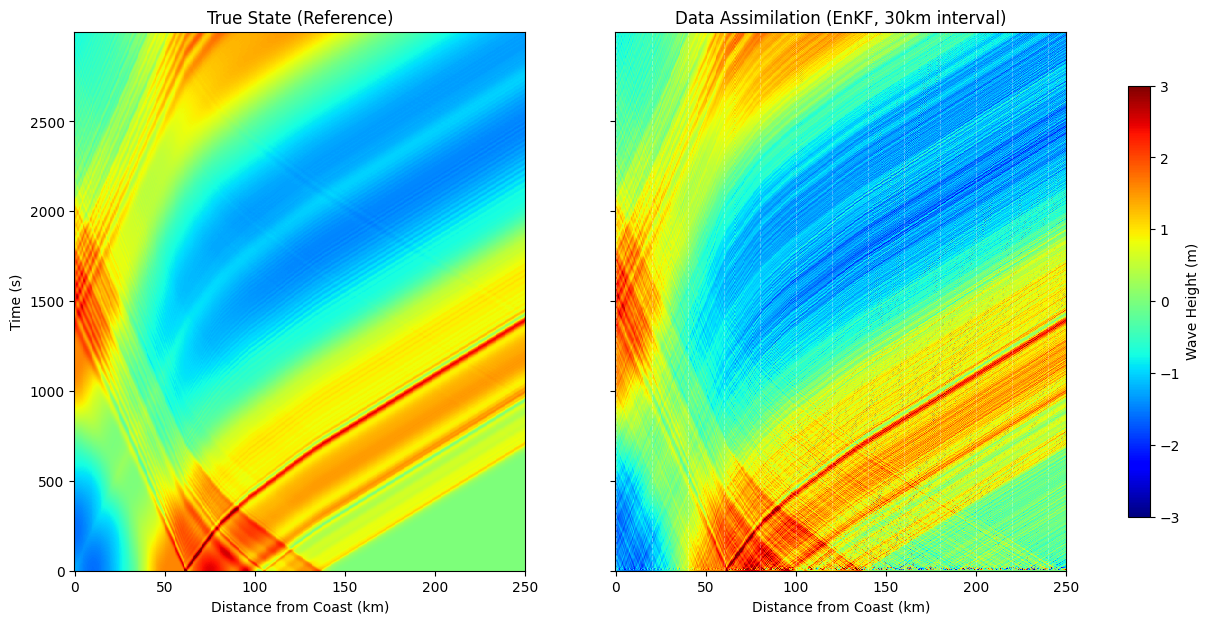

In [11]:
x_axis = np.linspace(0, 250, nx)
t_axis = np.linspace(0, nt * dt, nt)
X_mesh, T_mesh = np.meshgrid(x_axis, t_axis)

fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)

vmin, vmax = -3.0, 3.0

# 1. 真値 (True State)
im1 = axes[0].pcolormesh(X_mesh, T_mesh, eta_true_history, cmap='jet',
                         vmin=vmin, vmax=vmax, shading='auto')
axes[0].set_title('True State (Reference)')
axes[0].set_ylabel('Time (s)')
axes[0].set_xlabel('Distance from Coast (km)')

# 2. 同化結果 (EnKF Analysis)
im2 = axes[1].pcolormesh(X_mesh, T_mesh, eta_analysis_history, cmap='jet',
                         vmin=vmin, vmax=vmax, shading='auto')
axes[1].set_title('Data Assimilation (EnKF, 30km interval)')
axes[1].set_xlabel('Distance from Coast (km)')

# 観測地点を縦線（垂直線）で表示
for idx in obs_indices:
    axes[1].axvline(x=idx * dx / 1000, color='white', alpha=0.3, linestyle='--', linewidth=0.8)

fig.colorbar(im1, ax=axes.ravel().tolist(), label='Wave Height (m)', shrink=0.8)

plt.show()